In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas as pd

class ProcessAmazon():
    """Read, filter, aggregate by ProductId, and generate X matrix"""

    def __init__(self, raw_data_filename, num_reviews_filter):
        """Initialize attributes."""
        self.raw_data_filename = raw_data_filename
        self.num_reviews_filter = num_reviews_filter
        self.raw_data = self.read_and_report()
        self.grouped_by_userid = self.group_by_userid()
        self.filtered = self.filter_()
        self.grouped_by_productid = self.group_by_productid()
        self.X = self.write_X()
    
    def read_and_report(self):
        """Read Amazon csv, report on file structure"""
        data = pd.read_csv(self.raw_data_filename)
        print(self.raw_data_filename, "has", data.shape[0], "rows and", data.shape[1], "columns. First five observations:")
        print(data.head(5))
        print(50 * '-')
        return data
    
    def group_by_userid(self):
        """Group by UserId and look at the distribution of number of reviews"""
        grouped_by_uid = self.raw_data.groupby('UserId').count()
        print('Distribution of number of reviews for each UserId:')
        print(grouped_by_uid['ProductId'].value_counts())
        print(50 * '-')
        return grouped_by_uid
    
    def filter_(self):
        """Filter out reviewers with fewer than x reviews"""
        filtered = self.grouped_by_userid[self.grouped_by_userid['Id'] > self.num_reviews_filter]
        # remove redundant columns
        filtered_final = filtered.drop(filtered.columns[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]], axis=1)
        # recreate UserId from index
        filtered_final['UserId'] = filtered_final.index
        # rename columns
        filtered_final.columns = ['num_reviews', 'UserId']
        filtered_final.reset_index(drop=True, inplace=True)
        # left merge filtered list with raw data
        filtered = pd.merge(filtered_final, self.raw_data, how='left', on='UserId')
        print("Filtered data has", filtered.shape[0], "rows and", filtered.shape[1], "columns. First five observations:")
        print(filtered.head(5))
        print(50 * '-')
        return filtered
    
    def group_by_productid(self):
        """Group by ProductId and create a column that lists each UserId (separated by spaces) who reviewed that product"""
        grouped_by_pid = self.filtered.groupby('ProductId')['UserId'].apply(lambda x: ' '.join(x)).reset_index()
        print("Data grouped by ProductId has", grouped_by_pid.shape[0], "rows and", grouped_by_pid.shape[1], "columns. First five observations:")
        print(grouped_by_pid.head(5))
        print(50 * '-')
        return grouped_by_pid
    
    def write_X(self):
        """use bag of words to create boolean X to represent reviews by UserId (one UserId per column)"""
        from sklearn.feature_extraction.text import CountVectorizer
        count = CountVectorizer(ngram_range=(1, 2),token_pattern=r'\b\w+\b', min_df=20, max_df=50)
        uidArray = self.grouped_by_productid.UserId
        userFeatures = count.fit_transform(uidArray)
        print("Shape of final X matrix:", userFeatures.shape)
        return userFeatures

In [3]:
import pandas as pd
class ViewClusteringResults():
    """Merge cluster definitions to raw data and view samples of clustering results, showing review summaries and texts."""
    
    def __init__(self, data_instance, model_instance):
        """Initialize attributes"""
        self.data_instance = data_instance
        self.model_instance = model_instance
    
    def merge_labels(self):
        """Merge cluster labels to raw data (as structured in Amazon.csv)"""
        labels_tomerge = pd.DataFrame(self.model_instance.labels_)
        labelled_products = pd.concat([self.data_instance.grouped_by_productid, labels_tomerge], axis=1, ignore_index=True)
        labelled_products.columns = ['ProductId', 'UserIds', 'cluster']
        merged = pd.merge(labelled_products, self.data_instance.raw_data, how='left', on='ProductId')
        merged_lite = merged[['ProductId', 'cluster', 'Summary', 'Text']]
        return merged_lite

    def view_cluster_samples(self, n_samples):
        """Print x samples of cluster results for each cluster, showing details of product reviews."""
        merged = self.merge_labels()
        num_clusters = self.model_instance.cluster_centers_.shape[0]
        for i in range(1, num_clusters): 
            print(50 * '-')
            print('cluster: ', i)
            cluster = merged.loc[merged['cluster'] == i]
            print('cluster size: ', cluster.shape)
            print(cluster.sample(n_samples))

In [4]:
# process Amazon.csv, filtering out people who left 4 or fewer reviews
amazonData = ProcessAmazon('Amazon.csv', 4)

Amazon.csv has 455000 rows and 13 columns. First five observations:
   Unnamed: 0      Id   ProductId          UserId       ProfileName  \
0      138806  138807  B000E63LME  A1CQGW1AOD0LF2  Alena K. "Alena"   
1      469680  469681  B004ZIH4KM  A37S7U1OX2MCWI        Becky Cole   
2      238202  238203  B003ZXE9QA  A2OM6G73E64EQ9              jeff   
3      485307  485308  B001RVFERK  A25W349EE97NBK          Tangent4   
4      375283  375284  B000OQZNTS  A3CPPW0HUC07YS       Amy Nicolai   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       2      2  1294185600   
1                     0                       0      5  1349740800   
2                     0                       0      5  1329264000   
3                     1                       1      4  1248307200   
4                     0                       0      5  1333238400   

                     Summary  \
0           Not as pictured.   
1                   

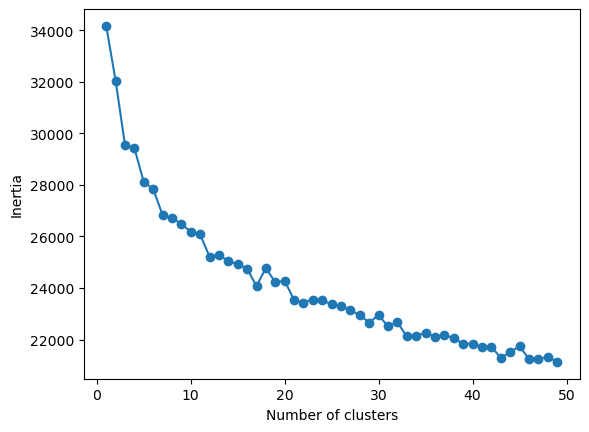

In [5]:
# first attempt at fitting K means to view change in Inertia
from sklearn.cluster import KMeans

# container to store inertia scores over iterations
distortions = []

# fit KMeans iteratively to begin to assess the appropriate number of clusters
for i in range(1, 50):
    km = KMeans(n_clusters=i)
    km.fit(amazonData.X)
    distortions.append(km.inertia_)
    
# vizualize change in inertia
plt.plot(range(1, 50), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [6]:
# fit KMeans with 10 clusters
from sklearn.cluster import KMeans
km = KMeans(n_clusters=9)
km.fit(amazonData.X)

KMeans(n_clusters=9)

In [7]:
# create an instance of ViewClusteringResults to view results of final KMeans fit
viz = ViewClusteringResults(amazonData, km)

In [8]:
# view samples of product reviews, organized by KMeans cluster results
viz.view_cluster_samples(10)

--------------------------------------------------
cluster:  1
cluster size:  (406, 4)
         ProductId  cluster                                         Summary  \
13575   B0002MLA5K        1                       Bought this for the Fiber   
273954  B003M60K54        1            The only thing all my cats will eat!   
13577   B0002MLA5K        1  Great product, but trust your vet not the hype   
273916  B003M60K54        1                   The only food I give my cats!   
274605  B003MW7858        1           wish I'd started using it 5 years ago   
274737  B003MWBFXY        1                          Best for Dental Health   
211359  B001VIYCK4        1                                           Meow!   
211348  B001VIYCK4        1     Terrible ingredients but my cat did eat it.   
274709  B003MWBFXY        1                   The only food I give my cats!   
274610  B003MW7858        1                                  Please avoid!!   

                                           

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',
                init='random', perplexity=3).fit_transform(amazonData.X)
X_embedded.shape

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
labels = km.labels_
for i, c in zip(range(9), colors):
    plt.scatter(X_embedded[labels == i, 0], X_embedded[labels == i, 1], c=c)
plt.legend()
plt.show()